# Benoît Choffin - Drug spectra challenge

<h1> <a href=http://www.datascience-paris-saclay.fr/>Paris Saclay Center for Data Science</a> </h1>

<h2> RAMP on qualitative and quantitative non-invasive monitoring of anti-cancer drugs </h2>

<i>Camille Marini (LTCI/CNRS), Alex Gramfort (LTCI/Télécom ParisTech), Sana Tfaili (Lip(Sys)²/UPSud), Laetitia Le (Lip(Sys)²/UPSud), Mehdi Cherti (LAL/CNRS), Balázs Kégl (LAL/CNRS)</i>

<h2> Introduction </h2>

<p>Chemotherapy is one of the most used treatment against cancer. It uses chemical substances (<a href=https://en.wikipedia.org/wiki/List_of_chemotherapeutic_agents>chemotherapeutic agents</a>) which kill cells that divide too quickly. These chemical substances are often diluted in a particular solution and packaged in bags, diffusers, or syringes, before being administered. <a href=https://books.google.fr/books?id=EB00rD8AqaYC&pg=PA188&lpg=PA188&dq=wrong+chemotherapeutic&source=bl&ots=m7EfyG6A3J&sig=ZVa0hLqDPFe2iExV6FOREJztN8c&hl=en&sa=X&ved=0ahUKEwj_5ZinkarMAhUFnBoKHaJiAgAQ6AEIKDAC#v=onepage&q=wrong%20chemotherapeutic&f=false>Wrong medication</a>  (wrong chemotherapeutic agent or wrong concentration) can have major impacts for patients. To prevent wrong medication, some recent French regulations impose the verification of anti-cancer drugs before their administration. The goal is to check that they contain the good chemotherapeutic agent with the good dosage. 

<p><a href=https://en.wikipedia.org/wiki/Raman_spectroscopy>Raman spectroscopy</a> could be used to make this check, since, theoretically, i) each molecule has a specific spectral fingerprint by which the molecule can be identified; and ii) the Raman intensity increases with the concentration of the molecule. The main advantage of spectroscopy above other methods (for example, liquid chromatography) is that it is non-destructive and non-invasive (measures are made without opening the drug containers). However, this method is rarely used in hospital environment because of the complexity of the spectral signals to analyze. Automating the analysis of these spectral signals could significantly help. Eventually, a complete analytical system (from measuring Raman spectra to identifying the chemotherapeutic agent and its concentration) could be designed, which would be easy to use and would prevent wrong medication. 

<p>In this context, the goal of this project is to develop prediction models able to <b>identify and quantify chemotherapeutic agents from their Raman spectra</b>.  

<p>The Lip(Sys)² laboratory measured Raman spectra of 4 types of chemotherapeutic agents (called <i>molecule</i>) in 3 different packages (called <i>vial</i>), diluted in 9 different solutions (called <i>solute gammes</i>), and having different concentrations. A total of <b>360 spectra were measured for each agent</b>, except for one (348 spectra).<br>  

Part of these data are saved in the file <code>train.csv</code> as follows (<code>n_samples</code> being the number of samples): 
<ul>
    <li><b>molecule</b>: Type of chemotherapeutic agent. Six possible values: A for infliximab, B for bévacizumab, Q for ramucirumab, R for rituximab. Dimension: (<code>n_samples</code>,)</li>
    <li><b>vial</b>: Vial type. Three possible values: 1, 2, 3. Dimension: (<code>1</code>, <code>n_samples</code>)</li>
    <li><b>solute</b>: Solute group. Fourteen possible values: 1, 2, ..., 14. Dimension: (<code>1</code>, <code>n_samples</code>)</li>
    <li><b>concentration</b>: Concentration of the molecule. Dimension: (<code>n_samples</code>, <code>1</code>)</li>
    <li><b>spectra</b>: Intensity of Raman spectrum. Dimension: (<code>n_samples</code>, <code>1866</code>)</li>
</ul>

<p>To sum up, there are too objectives:

<ul>
    <li><b>classification</b>: predict which molecule it corresponds to given the spectrum.</li>
    <li><b>regression</b>: predict the concentration of a molecule. The prediction should not depend on the vial or the solute group. The error metric is the mean absolute relative error (mare): $$\frac{1}{n_{samples}}\sum_{i=1}^{n_{samples}}\left|\frac{y_i-\hat{y}_i}{y_i}\right|$$ with $y$ and $\hat{y}$ being the true and predicted concentration.</li>
</ul>

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.17.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)   

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
from bokeh.charts import Scatter, output_notebook, show
output_notebook()

Loading BokehJS ...

## Statistiques exploratoires et analyse des données

Dans cette partie, nous nous attacherons à - comme son nom l'indique - explorer les données avec des visualisations et des statistiques descriptives. Nous compléterons cette analyse préliminaire par une analyse des données.

L'objectif est ici de préparer le terrain à la modélisation prédictive et obtenir un aperçu des relations entre les variables de notre base.

### Loading the data

In [2]:
data = pd.read_csv('train.csv')

y_df = data[['molecule', 'concentration']]
X_df = data.drop(['molecule', 'concentration'], axis=1)
spectra = X_df['spectra'].values                                        
spectra = np.array([np.array(dd[1:-1].split(',')).astype(float) for dd in spectra])    
X_df['spectra'] = spectra.tolist()

In [3]:
type(data['spectra'].values[0])

str

In [4]:
print(X_df.head())
print(y_df.head())

   solute                                            spectra  vial
0      11  [0.0152963, 0.0152944, 0.0153142, 0.0154096, 0...     1
1       1  [0.0143634, 0.0143292, 0.0143999, 0.0145162, 0...     1
2       3  [0.0163027, 0.0161848, 0.0163573, 0.0164119, 0...     1
3      10  [0.0135833, 0.0135537, 0.0134438, 0.0136424, 0...     2
4       2  [0.020811, 0.020767, 0.0208674, 0.0207018, 0.0...     3
  molecule  concentration
0        Q           8000
1        B            500
2        B           2000
3        A           2000
4        B          10000


In [5]:
# Loading wavenumbers
freqs = pd.read_csv('freq.csv')
freqs = freqs['freqs'].values
print(freqs.shape, spectra.shape)

(1866,) (999, 1866)


In [6]:
# Types of molecules
np.unique(y_df['molecule'].values)

array(['A', 'B', 'Q', 'R'], dtype=object)

In [7]:
# Target for classification
molecule = y_df['molecule'].values
# Target for regression
concentration = y_df['concentration'].values
# "Raw" features
X = spectra

### Some plots

#### Raman spectra

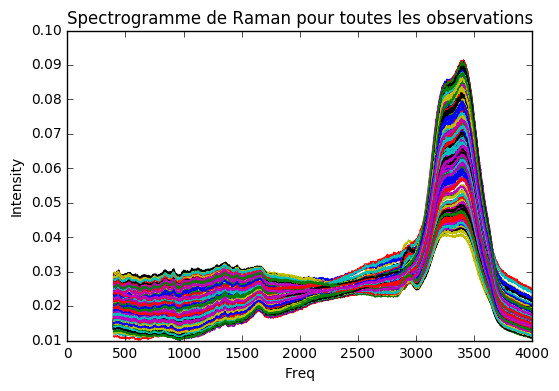

In [8]:
plt.plot(freqs, spectra.T)
plt.xlabel('Freq')
plt.ylabel('Intensity')
plt.title("Spectrogramme de Raman pour toutes les observations")
plt.show()

Le graphique du dessus présente le spectrogramme de chaque observation de la base, i.e. l'intensité de Raman en fonction de la fréquence. On remarque ici que la forme de chaque spectrogramme est similaire. Dès lors, il s'agira de trouver des *features* qui permettent de bien discriminer les molécules d'abord, et les concentrations ensuite. Par exemple, on peut voir qu'il y a un point d'inflexion dans le spectrogramme autour de 2300. En outre, la variance de certaines observations est bien plus forte que d'autres.

In [9]:
spectra.shape

(999, 1866)

#### Distribution of concentrations

Les graphiques ci-dessous représentent dans un premier temps la distribution de chaque concentration sous forme d'histogrammes, et ensuite cette distribution ventilée selon la molécule.

There are 21 different values of concentrations.


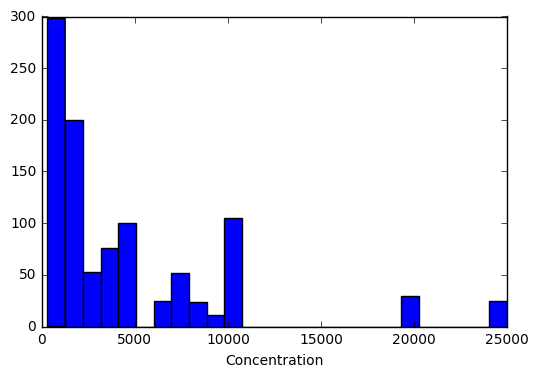

In [10]:
plt.hist(concentration, bins=26)
plt.xlabel('Concentration')
print("There are %s different values of concentrations." % np.unique(concentration).size)

[  300   400   600   800  1000  1400  1600  2000  5000 10000]
[  500  1000  1500  2000  4000  5000  7000 10000 20000 25000]
[ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000]
[  400   800  1000  1200  1600  2000  3000  4000  5000 10000]
La concentration minimale est de 300.
La concentration maximale est de 25000.


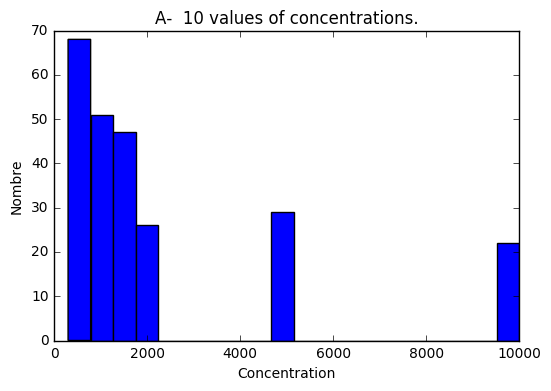

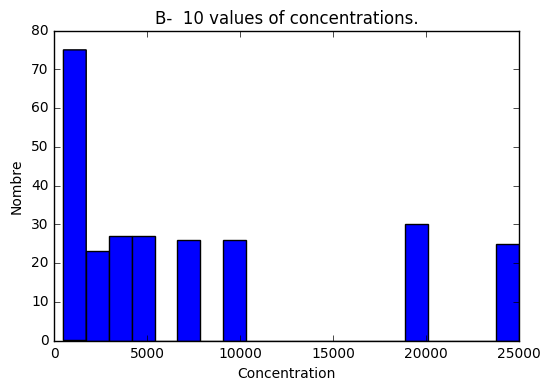

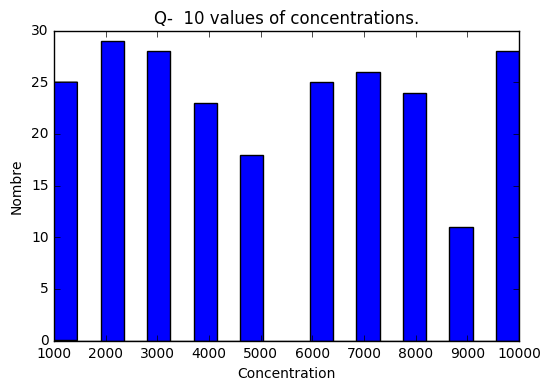

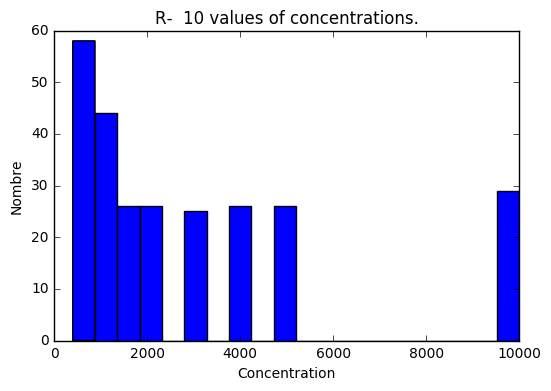

In [11]:
for mol in np.unique(molecule):
    plt.figure()
    plt.hist(concentration[molecule == mol], bins=20)
    plt.xlabel("Concentration")
    plt.ylabel("Nombre")
    plt.title(mol + "-  %s values of concentrations."
              % np.unique(concentration[molecule == mol]).size)
    print(np.unique(concentration[molecule == mol]))
print("La concentration minimale est de " + str(np.min(concentration)) + ".")
print("La concentration maximale est de " + str(np.max(concentration)) + ".")

Comme on peut le voir avec la liste du début, les concentrations présentes dans la base de données qui nous est laissée pour nous entraîner sont des entiers compris entre 300 et 25000. La majorité des concentratons est tout de même comprise entre 300 et 10000. Cela pose une première difficulté car il y a à peu près 50 **_outliers_** dans notre base. Prédire ces valeurs pourra nécessiter des procédures supplémentaires.

En outre, on constate que la distribution des concentrations dépend fortement de la molécule (A, B, Q ou R). Nous faisons donc face à une problématique de multi-label, dans laquelle on doit prédire la classe et la concentration de chaque observation en même temps. Dans notre cas, les deux variables à prédire semblent a priori liées. On pouvait s'en douter car il est peu probable que les différentes molécules servent à guérir les mêmes cancers ou qu'elles soient utilisées dans les mêmes situations. Dès lors, leur concentration peut tout à fait être amenée à varier.

In [12]:
from bokeh.charts import BoxPlot
temp = pd.DataFrame({'molecule':molecule,'concentration':concentration})

p = BoxPlot(temp, values='concentration', label='molecule',
            title="Boxplots des concentrations pour chaque molécule",color='molecule')
show(p)

Pour tester l'hypothèse nulle que chaque sous-échantillon (chaque *molécule*) provient de la même population, i.e. que les différences de concentration moyenne entre chaque molécule ne sont pas statistiquement significatives, je réalise ci-dessous un test ANOVA:

In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

test = ols('concentration ~ molecule',data=temp).fit()
table = sm.stats.anova_lm(test, typ=2)
print(table)

                sum_sq     df          F        PR(>F)
molecule  4.763019e+09    3.0  68.947706  1.636317e-40
Residual  2.291207e+10  995.0        NaN           NaN


Comme on peut le voir, la p-valeur associée à la variable "molécule" est extrêmement faible, on peut donc rejeter l'hypothèse nulle d'indépendance entre la variable catégorielle "molécule" et la variable numérique "concentration". Cela renforce notre décision d'utiliser l'une pour prédire l'autre.

En outre, il est a priori plus facile de prédire une variable catégorielle qu'une variable continue, on peut donc chercher à prédire la molécule **avant** la concentration.

Enfin, il convient de remarquer que les valeurs de concentration des molécules sont des entiers. Elle ne prennent pas dans la base de valeurs autres que des multiples de 10. Beaucoup de concentrations sont égales. Toutefois, il serait impossible d'utiliser ici un modèle de classification car ce ne sont probablement pas les seules valeurs de concentration que l'on peut rencontrer pour ces molécules en chimiothérapie. Il est d'ailleurs tout à fait possible que d'autres valeurs de concentration existent au sein de la base de test du RAMP.

#### Proportion of molecules

Number of samples: 999


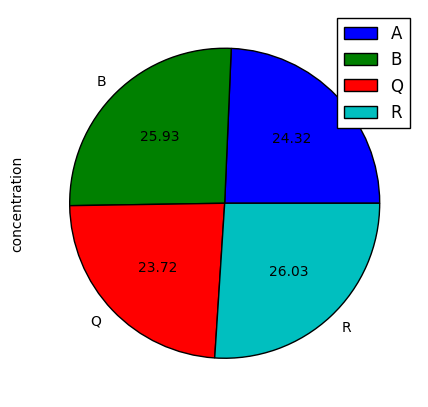

In [14]:
print('Number of samples: %s' % len(y_df))
y_df.groupby('molecule').count().plot(y='concentration', kind='pie', autopct='%.2f', figsize=(5, 5));

Le graphique ci-dessus nous montre la répartition des molécules au sein de la base. Pas de souci à ce niveau-là, on n'est pas en présence de classes déséquilibrées.

#### Proportion of solute groups and vial group

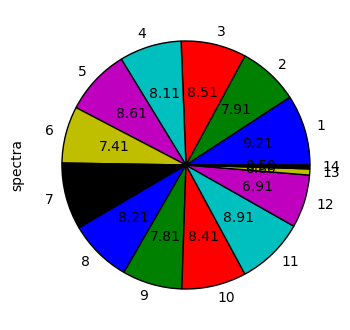

In [15]:
X_df.groupby('solute').count().plot(y='spectra', kind='pie', autopct='%.2f', figsize=(4, 4), legend=None);

Ici, on a la répartition des solutés au sein de la base. Même chose, les classes sont relativement équilibrées, sauf pour les 13 et 14. Cela ne risque pas de poser de problème, étant donné que ce ne sont pas des classes à prédire. Étudions tout de même la répartition des molécules et des concentrations au sein de chaque soluté:

In [16]:
solute=X_df['solute'].values
temp = pd.DataFrame({'molecule':molecule,'concentration':concentration,'solute':solute})

p = BoxPlot(temp, values='concentration', label='solute',
            title="Boxplots des concentrations pour chaque soluté",color='solute')
show(p)

Les différences de concentration entre solutés ne semblent pas être significatives (à part pour les solutés 13 et 14). Nous n'allons donc pas intégrer cette variable dans nos modélisations futures. Ce choix est motivé également par la nécessité qu'il y aurait eu de créer une *dummy* pour chaque modalité (i.e. 14).

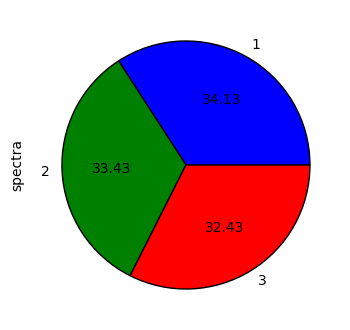

In [17]:
X_df.groupby('vial').count().plot(y='spectra', kind='pie',  autopct='%.2f', figsize=(4, 4), legend=None)

Idem ici, les différents vials sont répartis de manière homogène dans la population.

In [18]:
vial=X_df['vial'].values
temp = pd.DataFrame({'molecule':molecule,'concentration':concentration,'vial':vial})

p = BoxPlot(temp, values='concentration', label='vial',
            title="Boxplots des concentrations pour chaque vial",color='vial')
show(p)

Idem ici, la distribution de la concentration semble très similaire selon chaque vial.

#### Mean Raman spectra for each concentration value

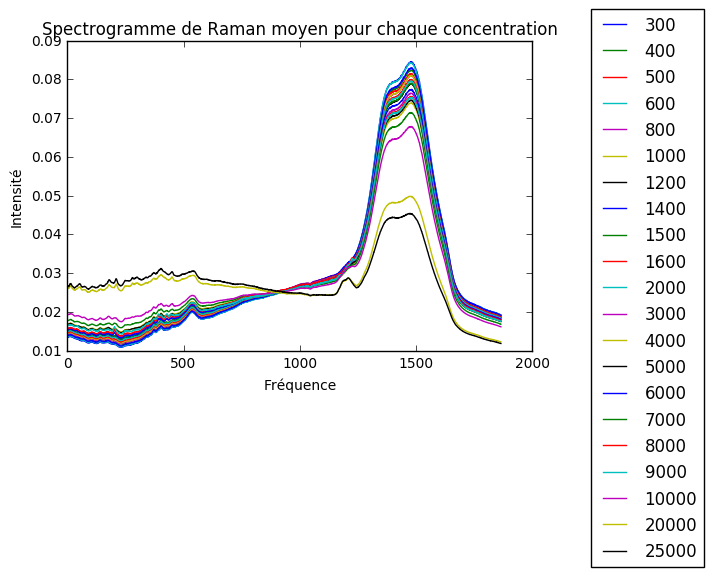

In [19]:
for c in np.unique(concentration):
    plt.plot(np.mean(X[concentration == c, :], axis=0), label="%s" % c)
    plt.xlabel('Fréquence')
    plt.ylabel('Intensité')
plt.title('Spectrogramme de Raman moyen pour chaque concentration')
plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

Le graphique ci-dessus montre la moyenne de chaque spectrogramme pour chaque concentration différente. On s'aperçoit ici que le point d'inflexion que l'on avait observé auparavant diffère bien selon la concentration. Avant ce point d'inflexion (situé à une fréquence d'environ 900), l'intensité est à peu près stationnaire pour les valeurs très hautes de concentration (20000 et 25000), tandis qu'elle est décroissante jusqu'à 250, puis croissante pour les autres concentrations. Il semble que plus la concentration augmente, et plus le spectrogramme passe **de convexe à concave**. Les valeurs absolues de signature spectrale sont en outre ordonnées selon la concentration avant ce point d'inflexion. Après le point d'inflexion, l'ordre des spectrogrammes s'inverse: les observations avec la plus forte intensité sont celles dont la concentration est la plus faible.

### Recherche de *features* pertinentes

Visualisons maintenant la distribution des variances des spectrogrammes en fonction de la molécule:

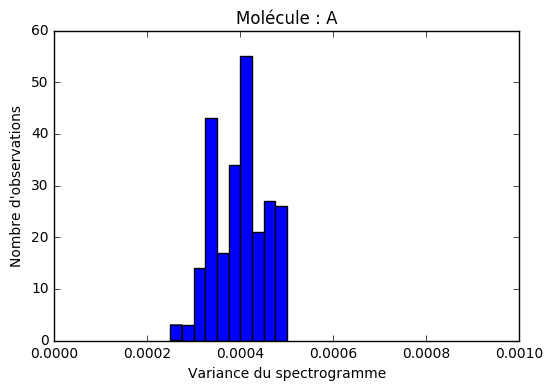

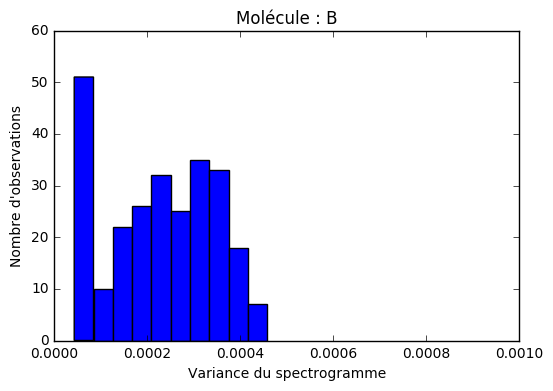

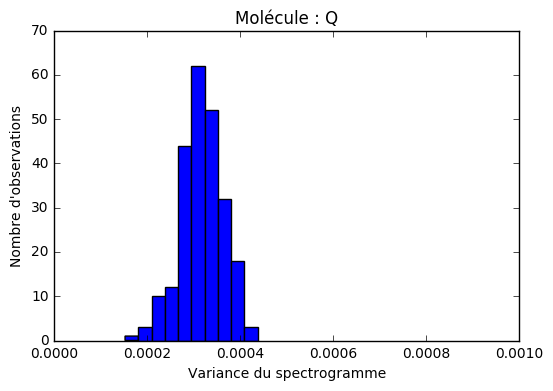

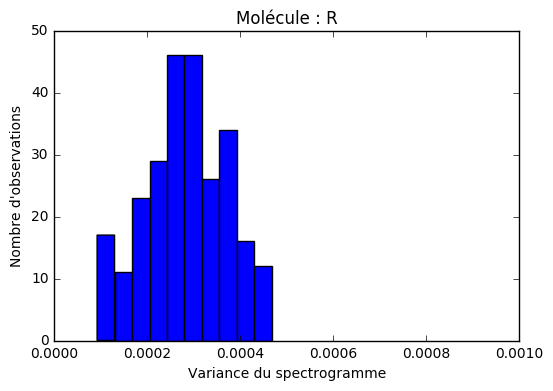

In [20]:
for mol in np.unique(molecule):
    plt.figure()
    plt.hist(np.var(np.array([np.array(dd) for dd in X_df['spectra']]),axis=1)[molecule == mol].T)
    plt.xlabel('Variance du spectrogramme')
    plt.ylabel("Nombre d'observations")
    plt.title("Molécule : "+str(mol))
    plt.xlim((0,0.001))

La variance de l'intensité du spectrogramme comme *feature* pourrait aider à discriminer certaines classes les unes entres les autres (par exemple, entre les molécules A et B). Néanmoins, elle semble assez limitée. Testons d'autres statistiques/mesures de forme du spectrogramme:

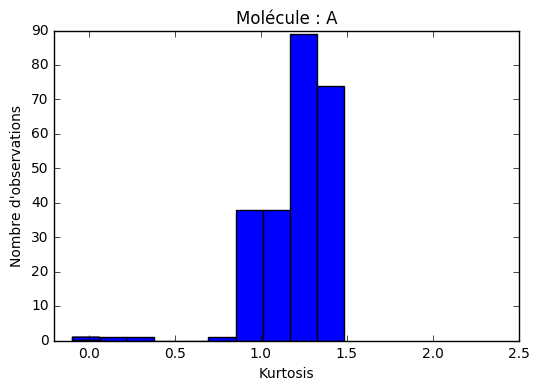

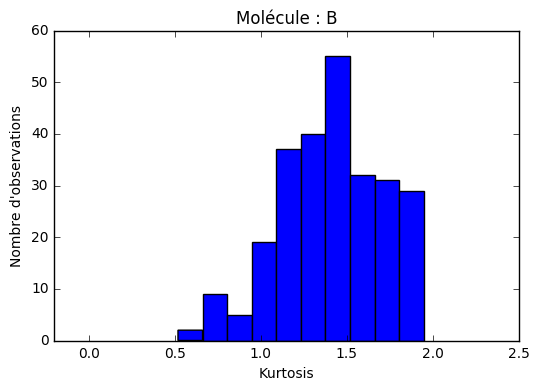

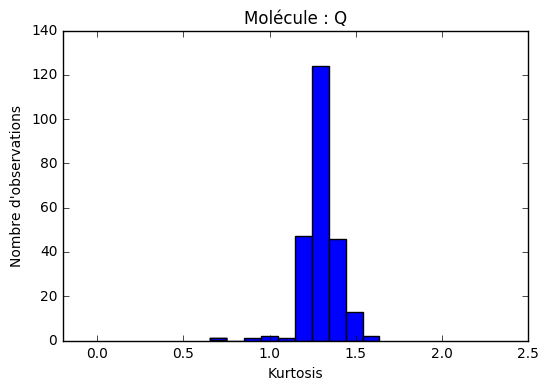

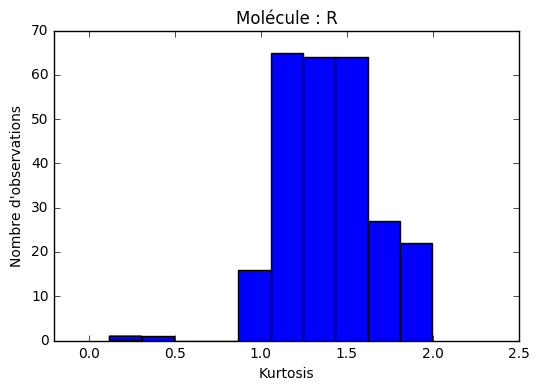

In [21]:
#Tests for different statistics
from scipy.stats import kurtosis
from scipy.stats import skew
spectra=np.array([np.array(dd) for dd in X_df['spectra']])

kurto = kurtosis(spectra,axis=1)
for mol in np.unique(molecule):
    plt.figure()
    plt.hist(kurto[molecule == mol].T)
    plt.xlim((-0.2,2.5))
    plt.xlabel("Kurtosis")
    plt.ylabel("Nombre d'observations")
    plt.title("Molécule : "+str(mol));

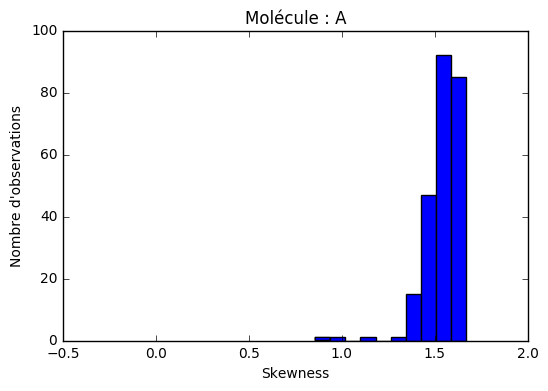

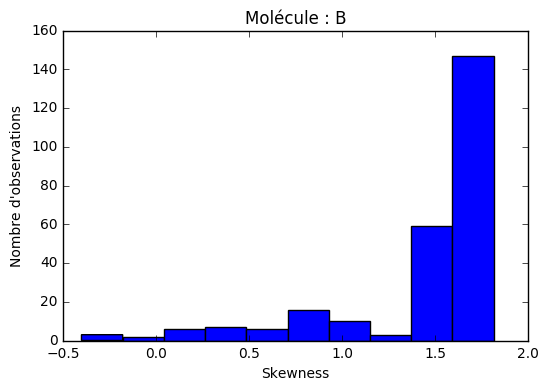

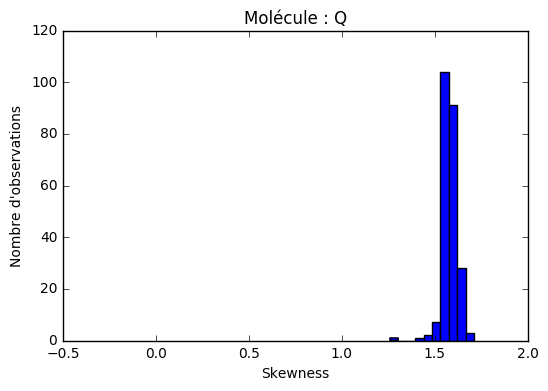

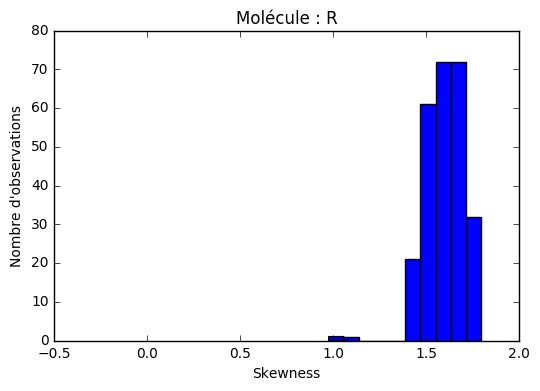

In [22]:
sk = skew(spectra,axis=1)
for mol in np.unique(molecule):
    plt.figure()
    plt.hist(sk[molecule == mol].T)
    plt.xlim((-0.5,2))
    plt.xlabel("Skewness")
    plt.ylabel("Nombre d'observations")
    plt.title("Molécule : "+str(mol));

Même remarque que précédemment. Ces deux statistiques pourraient permettre de discriminer certaines molécules entre elles mais cela semble incertain.

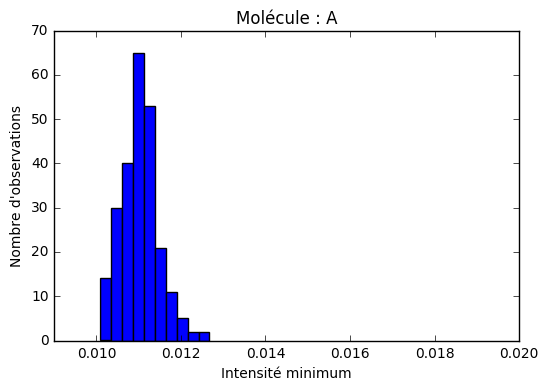

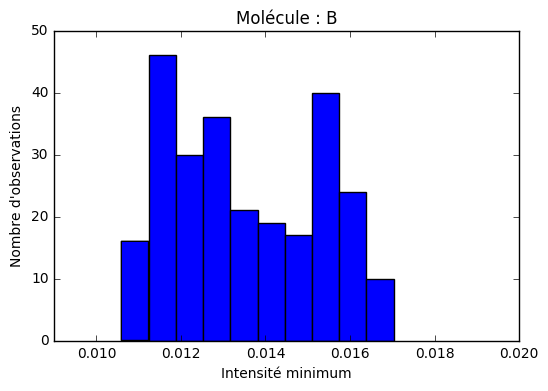

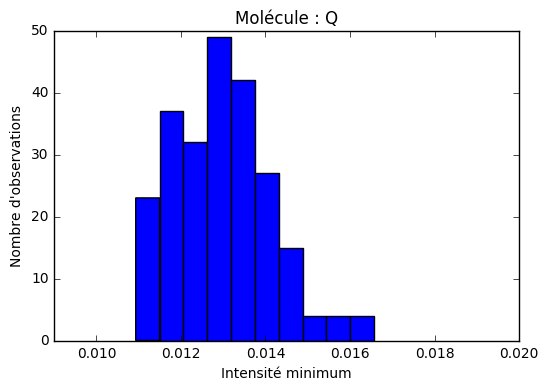

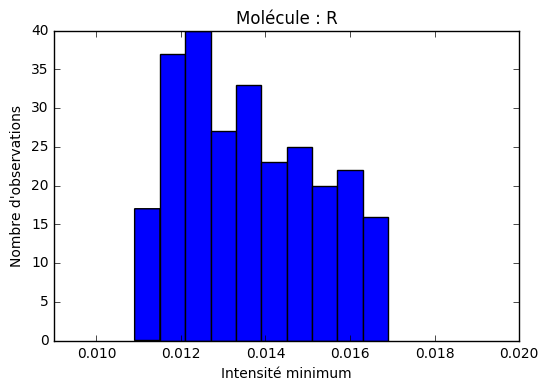

In [23]:
mini = np.min(spectra,axis=1)
for mol in np.unique(molecule):
    plt.figure()
    plt.hist(mini[molecule == mol].T)
    plt.xlabel("Intensité minimum")
    plt.ylabel("Nombre d'observations")
    plt.xlim((0.009,0.02))
    plt.title("Molécule : "+str(mol));

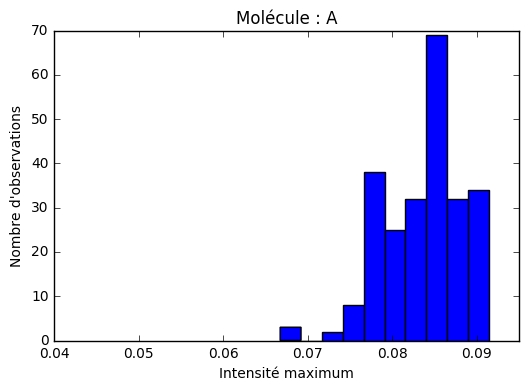

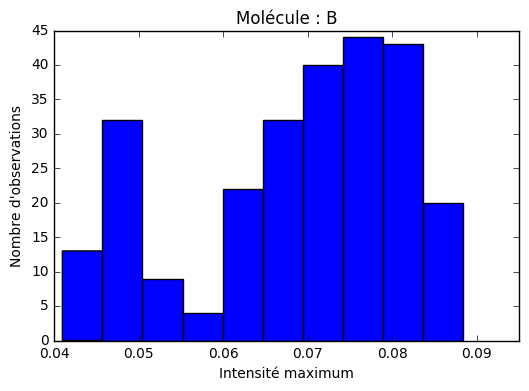

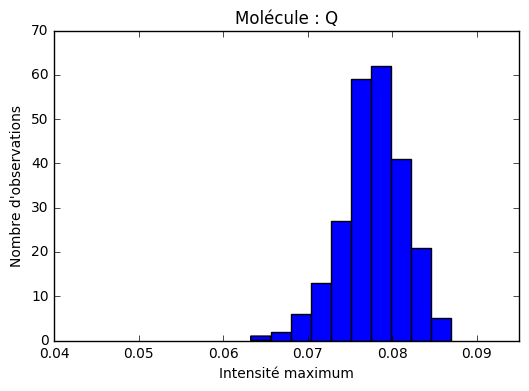

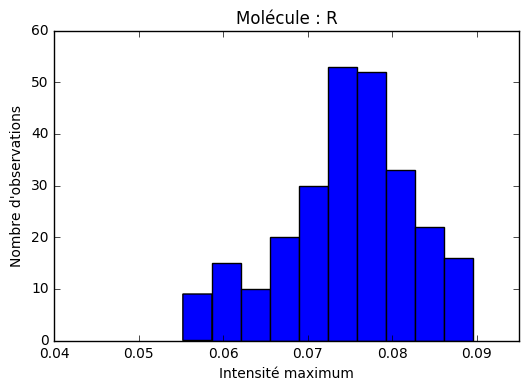

In [24]:
maxi = np.max(spectra,axis=1)
for mol in np.unique(molecule):
    plt.figure()
    plt.hist(maxi[molecule == mol].T)
    plt.xlabel("Intensité maximum")
    plt.ylabel("Nombre d'observations")
    plt.xlim((0.04,0.095))
    plt.title("Molécule : "+str(mol));

Même analyse. Le min et le max de chaque spectrogramme sont généralement concentrés sur les mêmes valeurs. J'ai aussi pensé que la fréquence pour laquelle le minimum (ou le maximum) du spectrogramme était atteint pouvait nous donner des indices sur la molécule, du fait de la convexité (ou concavité) relevée avant le point d'inflexion au début de ce notebook. Malheureusement, les graphiques suivants m'ont dissuadé d'utiliser ces *features*:

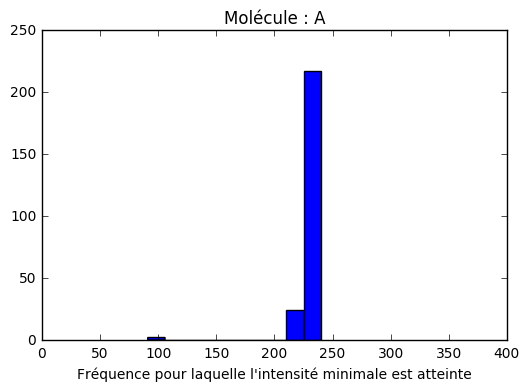

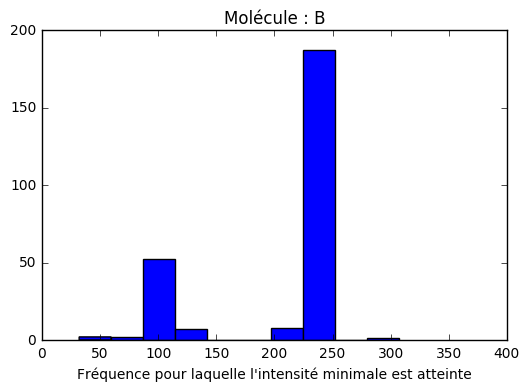

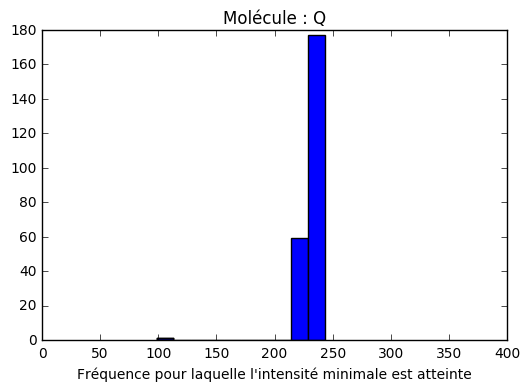

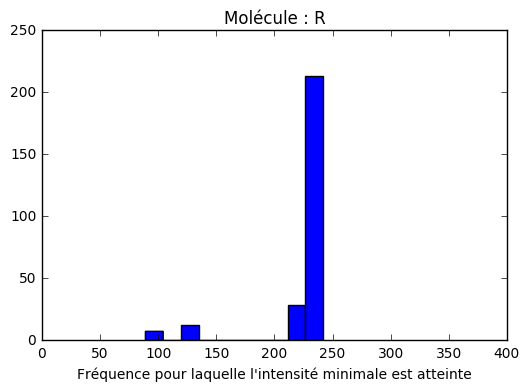

In [25]:
mini = np.argmin(spectra[:,[i for i in range(400)]],axis=1)
for mol in np.unique(molecule):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    plt.hist(mini[molecule == mol].T)
    plt.xlim((0,400))
    ax.set_xlabel("Fréquence pour laquelle l'intensité minimale est atteinte")
    plt.title("Molécule : "+str(mol));

#### Raman spectra for each type of molecule

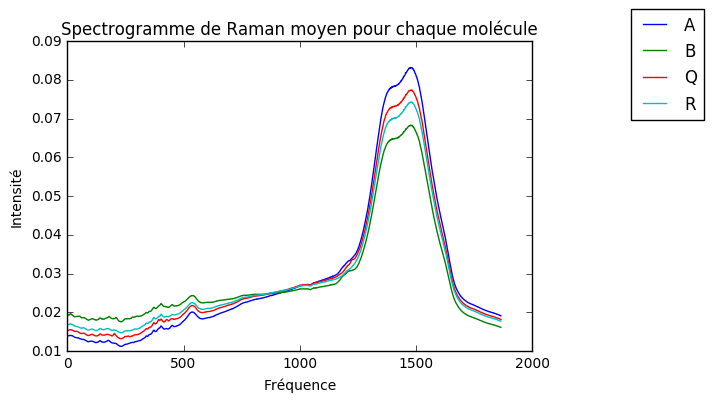

In [26]:
# Mean Raman spectra for each type of molecule
for mol in np.unique(molecule):
    plt.plot(np.mean(X[molecule == mol, :], axis=0), label="%s" % mol)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);
plt.title("Spectrogramme de Raman moyen pour chaque molécule")
plt.xlabel("Fréquence")
plt.ylabel("Intensité")
plt.show()

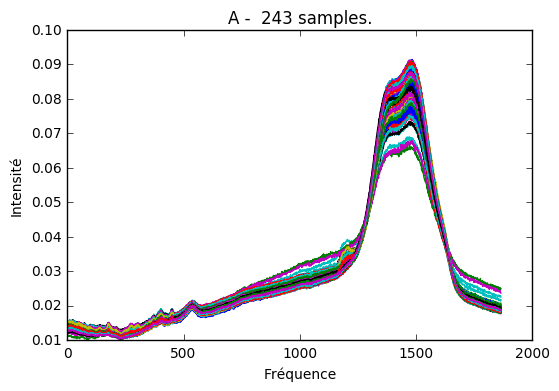

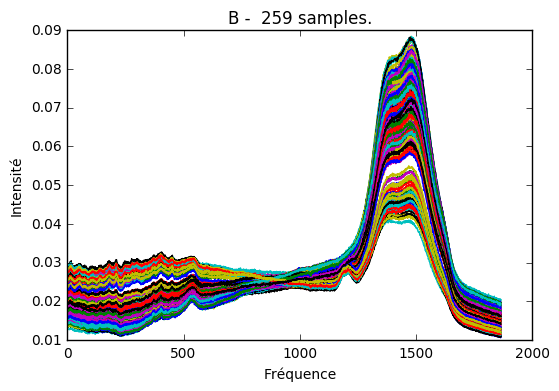

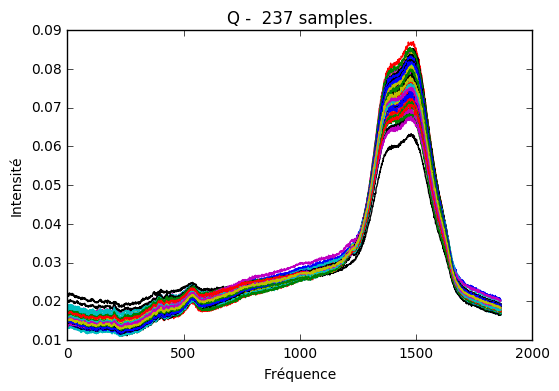

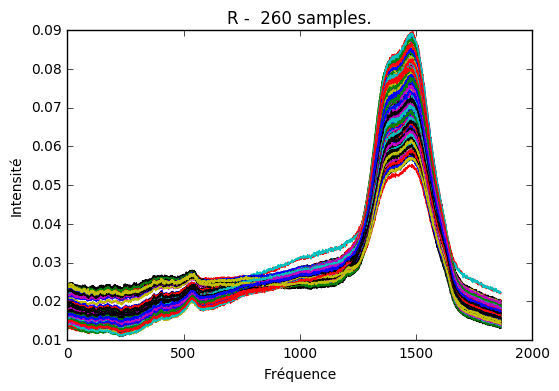

In [27]:
# For each molecule
for mol in np.unique(molecule):
    plt.figure()
    plt.plot(X[molecule == mol, :].T)
    plt.title(mol + " -  %s samples." % X[molecule == mol, :].shape[0]);
    plt.xlabel("Fréquence")
    plt.ylabel("Intensité")

/Users/benoitchoffin/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


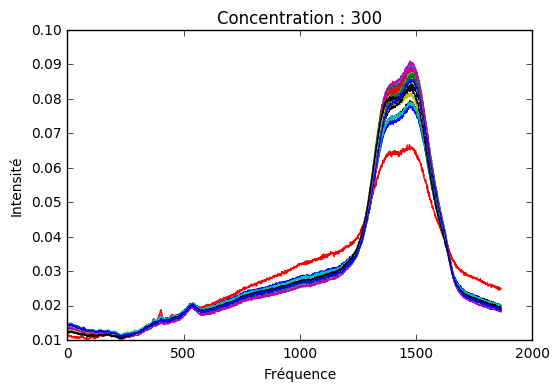

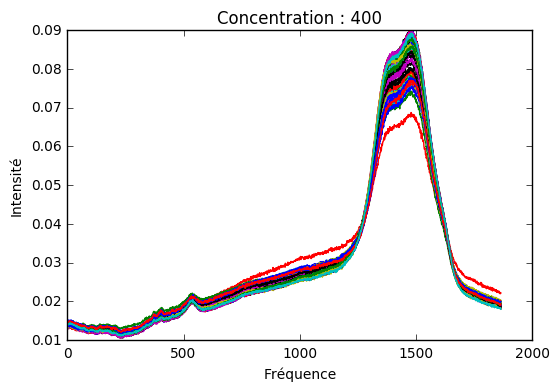

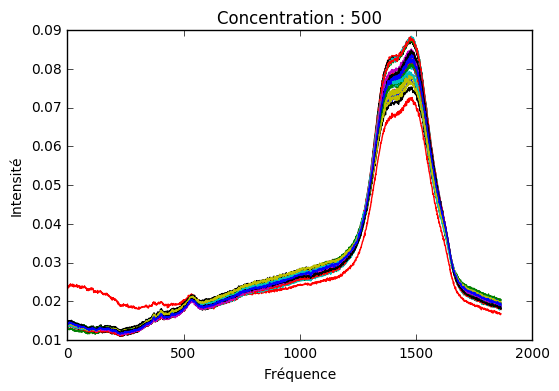

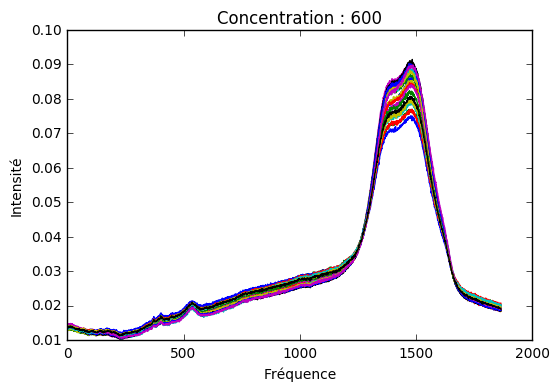

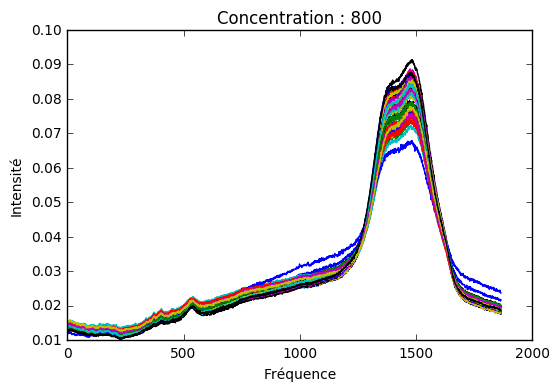

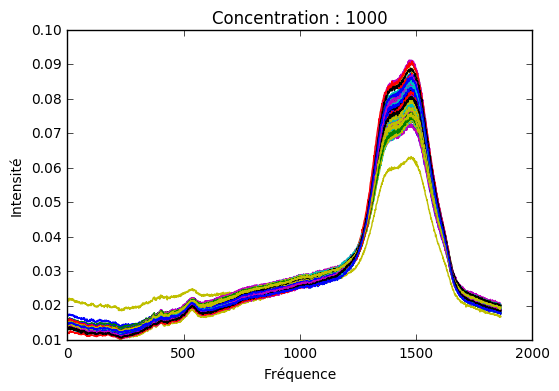

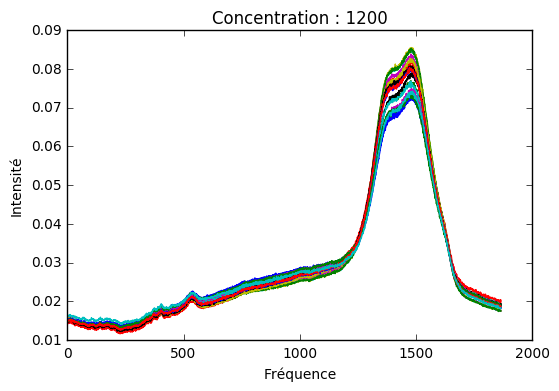

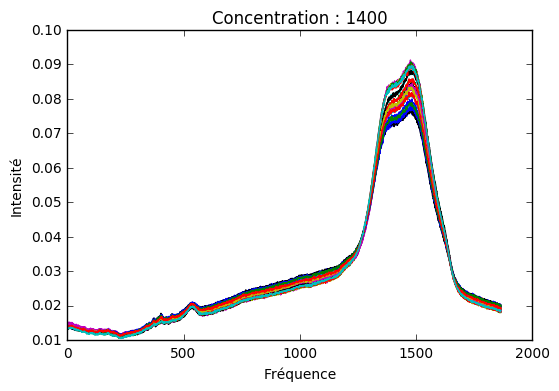

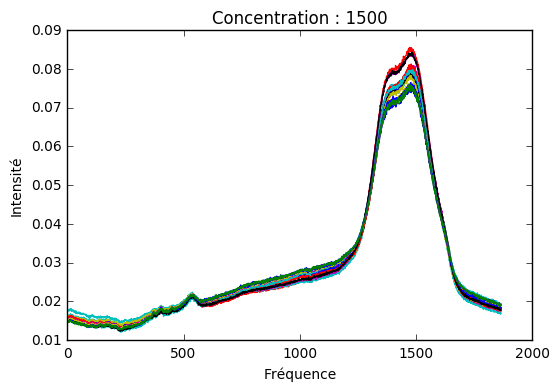

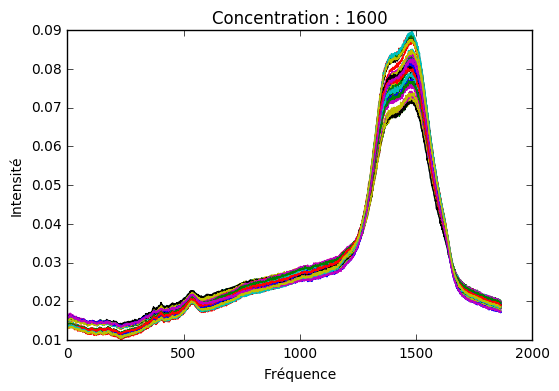

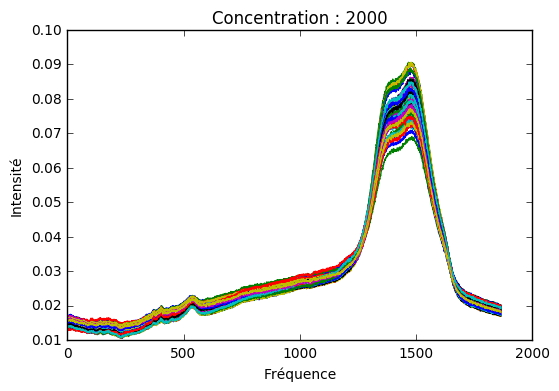

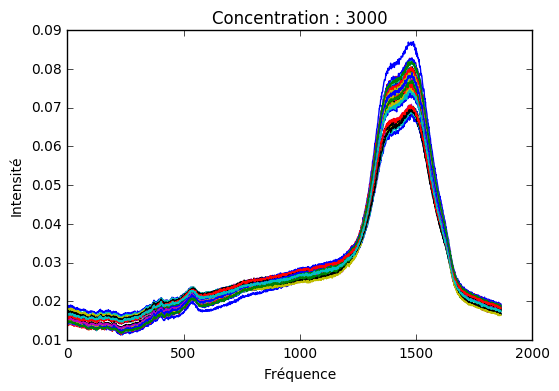

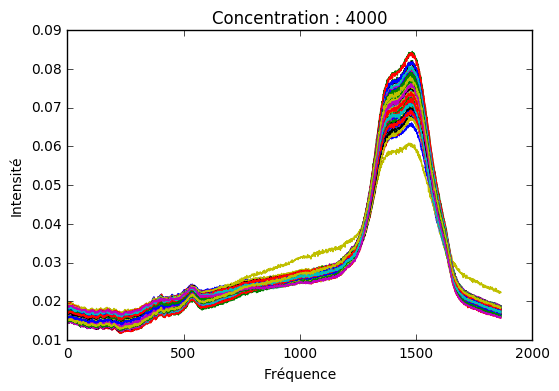

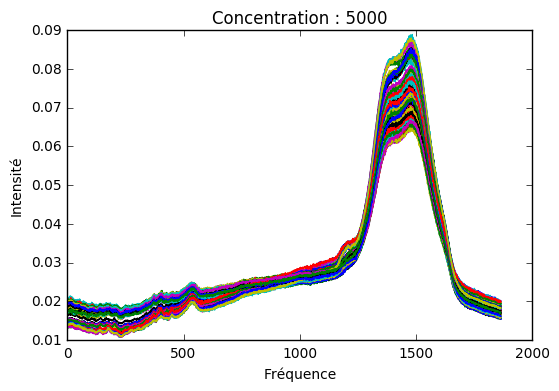

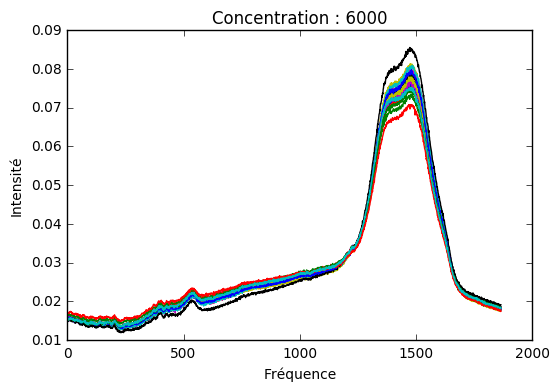

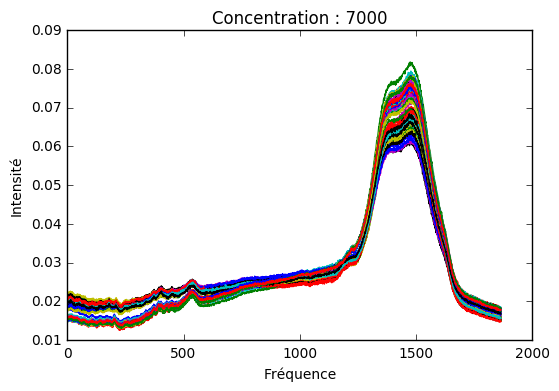

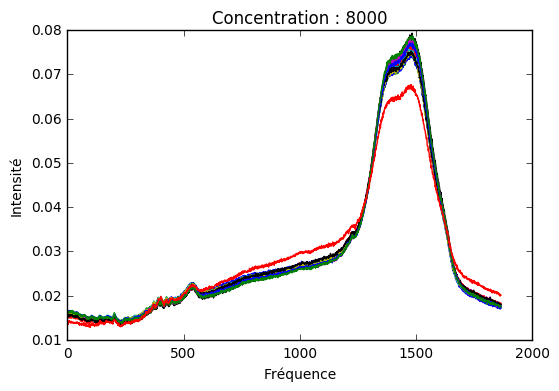

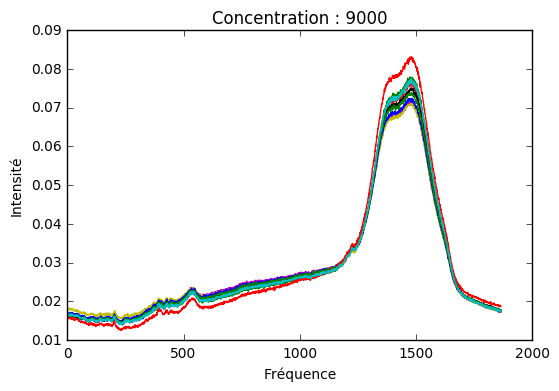

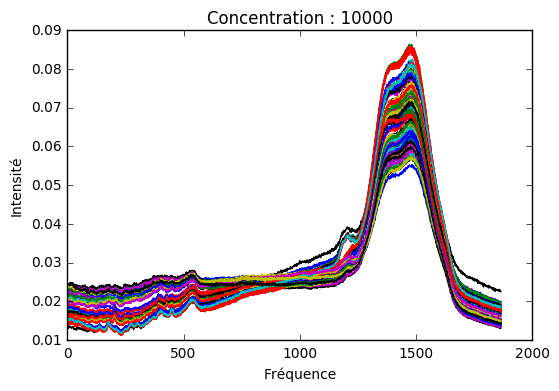

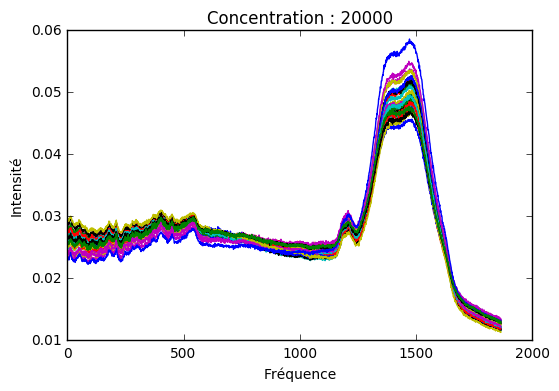

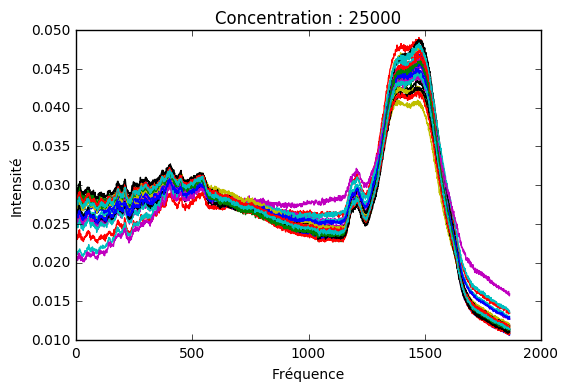

In [28]:
# For each concentration
for conc in np.unique(concentration):
    plt.figure()
    plt.plot(X[concentration == conc, :].T)
    plt.xlabel("Fréquence")
    plt.ylabel("Intensité")
    plt.title("Concentration : "+str(conc));

## Analyse des données

Faisons maintenant de l'analyse des données sur les spectrogrammes. C'est nécessaire car le nombre de *features* est bien trop élevé et nécessite une réduction de dimension.

In [29]:
from sklearn.decomposition import PCA

spectra=np.array([np.array(dd) for dd in X_df['spectra']])
pre_pca=PCA(n_components=3).fit(spectra)
pca=pre_pca.transform(spectra)

In [30]:
a=pd.DataFrame()
a["contribution"] = pre_pca.explained_variance_ratio_
a["component"] = ['comp1','comp2','comp3']
a.head()

,contribution,component
0,0.948528,comp1
1,0.041683,comp2
2,0.004482,comp3


In [31]:
from bokeh.charts import Bar
p = Bar(a, 'component', values='contribution', title="Part de la variance expliquée par chaque composante")
show(p)

Une proportion importante de la variance est expliquée par le premier axe (95%). Malheureusement, le premier plan ne discrimine pas vraiment les molécules entre eux, comme nous le montrent les graphiques ci-dessous.

In [32]:
toplot=pd.DataFrame(np.concatenate((pca,np.array(y_df['molecule']).reshape(-1,1)),axis=1),columns=['comp1','comp2','comp3','molecule'])
toplot[['comp1','comp2','comp3']] = toplot[['comp1','comp2','comp3']].apply(pd.to_numeric)

In [33]:
p1 = Scatter(toplot, x='comp1', y='comp2', title="Projection sur les deux premières composantes de l'ACP",
            color='molecule')
p2 = Scatter(toplot, x='comp1', y='comp3', title="Projection sur les composantes 1 et 3 de l'ACP",
            color='molecule')
p3 = Scatter(toplot, x='comp2', y='comp3', title="Projection sur les composantes 2 et 3 de l'ACP",
            color='molecule')
show(p1)
show(p2)
show(p3)

## Modélisation prédictive: classification

J'ai rajouté les *features* qui étaient ressorties de l'analyse préalable: variance, kurtosis, skewness.

In [37]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
from scipy.stats import skew

class FeatureExtractorClf(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_df):
        pass
    
    def transform(self, X_df):
        temp=np.concatenate((np.array([np.array(dd) for dd in X_df['spectra']]),
                             np.array([np.var(np.array([np.array(dd) for dd in X_df['spectra']]),axis=1)]).T,
                             np.array([kurtosis(np.array([np.array(dd) for dd in X_df['spectra']]),axis=1)]).T,
                             np.array([skew(np.array([np.array(dd) for dd in X_df['spectra']]),axis=1)]).T),axis=1)
        return temp

### Classification: predicting the molecule type

Il est important de bien prédire la molécule car c'est ce qui nous permettra de bien prédire la concentration. J'ai commencé par réduire le nombre de dimensions avec une ACP et je n'ai retenu que les 50 premières composantes au vu de la section précédente.

Le modèle *baseline* était un modèle d'arbres de type "Random Forest" précédé d'une ACP pour réduire la dimension. J'ai dans un premier temps voulu tester des modèles plus "complexes" (notamment, Gradient Boosting), et toujours d'arbres, car les résultats me semblaient alors plutôt bons. J'ai ainsi effectué une recherche des meilleurs hyperparamètres sur ces modèles, mais aucun ne parvenait à passer en-dessous d'un taux de mal classés de 0.07. J'ai aussi essayé de réaliser un clustering pour rajouter les clusters en *feature* afin d'assister le modèle de classification, mais les résultats n'étaient pas satisfaisants. Il est probable que l'espace de représentation ne soit pas le plus adapté.

J'ai alors réalisé que j'avais commis une erreur "classique" : j'avais cherché à utiliser des modèles plus complexes, alors que la simplicité était peut-être la solution la meilleure ici. J'ai donc dans un second temps entraîné un modèle de régression logistique pénalisée. J'ai utilisé la pénalisation L1 car je cherchais encore à supprimer des variables non-significatives. J'ai ainsi obtenu des résultats bien meilleurs que précédemment (de l'ordre de 0.04 contre 0.08 auparavant). J'ai également réalisé un *grid search* (à la "main") pout optimiser la force de la pénalisation, tout en enlevant la *seed* pour éviter de surapprendre sur la partition qui était donnée.

J'ai également voulu tester une hypothèse que j'avais formulée au vu des spectrogrammes des observations. Les différences entre classes (et concentrations) sont très locales et il me semblait qu'un classifieur qui tiendrait compte de ces proximités et différences locales serait la clef du succès. Je souhaitais donc entraîner un modèle qui tiendrait compte de cette proximité géométrique. J'ai donc entraîné un classificateur SVM avec différents kernels. Le meilleur kernel était de loin le kernel rbf et j'ai aussi optimisé mes hyperparamètres. Là encore, j'ai obtenu des résultats comparables à ceux de la régression logistique.

Partant de ce constat, j'ai choisi de combiner les forces de ces trois types d'algorithmes en les faisant voter entre eux. Les résultats étaient légèrement meilleurs que le meilleur des classifieur.

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

class Classifier(BaseEstimator):
    def __init__(self):
        self.n_components = 50
        self.n_estimators = 2000
        self.gamma=10
        self.C=500
        self.random_state=42
        self.clf = Pipeline([
            ('pca', PCA(n_components=self.n_components)),
            ('voting',VotingClassifier(voting='soft',estimators=[('log',LogisticRegression(C=6000,penalty='l1',class_weight='balanced')),
                                                ('svm',SVC(kernel='rbf',gamma=self.gamma,probability=True,C=self.C)),
                                                ('xtra',ExtraTreesClassifier(n_estimators=self.n_estimators)),
                                                ('rf',RandomForestClassifier(n_estimators=self.n_estimators,max_depth=7))]))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [39]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

labels = np.array(['A', 'B', 'Q', 'R'])

def train_test_model_clf(X_df, y_df, skf_is, FeatureExtractor, Classifier):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()
    y_train_clf = y_train_df['molecule'].values
    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy() 
    y_test_clf = y_test_df['molecule'].values 
    # Feature extraction
    fe_clf = FeatureExtractorClf()
    fe_clf.fit(X_train_df, y_train_df)
    X_train_array_clf = fe_clf.transform(X_train_df)
    X_test_array_clf = fe_clf.transform(X_test_df)
    # Train
    clf = Classifier()
    clf.fit(X_train_array_clf, y_train_clf)
    
    # Test 
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print('error = %s' % error)                                                                            
    print('classification report:\n %s' % classification_report(y_test_clf, y_pred_clf))
    print('confusion matrix:\n %s' % confusion_matrix(y_test_clf, y_pred_clf))


skf = ShuffleSplit(n_splits=2, test_size=0.2)#, random_state=42)  
skf_is = list(skf.split(X_df))[0]

train_test_model_clf(X_df, y_df, skf_is, FeatureExtractorClf, Classifier)

error = 0.045
classification report:
              precision    recall  f1-score   support

          A       0.98      1.00      0.99        43
          B       1.00      0.88      0.94        66
          Q       1.00      0.98      0.99        41
          R       0.86      1.00      0.93        50

avg / total       0.96      0.95      0.96       200

confusion matrix:
 [[43  0  0  0]
 [ 0 58  0  8]
 [ 1  0 40  0]
 [ 0  0  0 50]]


J'obtiens un taux d'erreur compris entre 2.5% et 5.5%.

Mais des points faibles subsistent: il est souvent difficile de prédire toutes les valeurs de B, et l'algorithme confond régulièrement la molécule B et la molécule R (comme le montre la matrice de confusion au-dessus). On pourrait poursuivre l'étude en concevant un kernel adapté à la situation et qui permettrait de trouver un espace de représentation où les molécules seraient mieux séparées. De même, un réseau de neurones pourrait permettre - à l'instar de la reconnaissance vocale - de reconnaître encore mieux les molécules à partir de leur signature spectrale.

## Modélisation prédictive: régression

Nous avons vu que les variables qui influaient sur la concentration influaient aussi sur la molécule, nous allons donc utiliser les mêmes *features*. Les résultats de la classification sont intégrés comme *features*, du fait de la dépendance dont nous avons parlé plus haut.




In [40]:
labels = np.array(['A', 'B', 'Q', 'R'])

class FeatureExtractorReg(object):
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass
    
    def transform(self, X_df):                                                   
        XX = np.array([np.array(dd) for dd in X_df['spectra']])                  
        XX -= np.mean(XX, axis=1)[:, None]                                     
        XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]                          
        XX = np.concatenate([XX, X_df[labels].values], axis=1)
        temp=np.concatenate((XX,
                             np.array([np.var(np.array([np.array(dd) for dd in X_df['spectra']]),axis=1)]).T,
                             np.array([kurtosis(np.array([np.array(dd) for dd in X_df['spectra']]),axis=1)]).T,
                             np.array([skew(np.array([np.array(dd) for dd in X_df['spectra']]),axis=1)]).T),axis=1)
        return XX

J'ai mené à bien le même processus que précédemment en essayant d'abord d'optimiser le modèle baseline (*Gradient Boosting*). Là encore, la clef résidait dans l'utilisation de modèles simples. J'ai donc entraîné une régression linéaire "classique", sans pénalisation, et je n'ai pas réussi à battre ses performances en la pénalisant.




In [41]:
from sklearn.ensemble import GradientBoostingRegressor                           
from sklearn.decomposition import PCA                                            
from sklearn.pipeline import Pipeline                                            
from sklearn.base import BaseEstimator 
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import numpy as np                                                               
                                                                                 
                                                                                 
class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 100                                                  
        self.n_estimators = 400                                                   
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}                                                       
        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('lin',LinearRegression())
            ])                                                                   
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, y_mol)                        
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = self.dict_reg[mol].predict(XX_mol)         
        return y_pred                                                                            

## Mettons ces deux modèles ensemble...

In [42]:
def mare_score(y_true, y_pred):                                                  
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()                                  
    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy()                                    
    y_train_clf = y_train_df['molecule'].values                              
    y_train_reg = y_train_df['concentration'].values                         
    y_test_clf = y_test_df['molecule'].values                                
    y_test_reg = y_test_df['concentration'].values                           

    # Classification
    fe_clf = FeatureExtractorClf()                     
    fe_clf.fit(X_train_df, y_train_df)                                       
    X_train_array_clf = fe_clf.transform(X_train_df)                         
    X_test_array_clf = fe_clf.transform(X_test_df)                           
                                                                                 
    clf = Classifier()                                            
    clf.fit(X_train_array_clf, y_train_clf)                                  
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print('error = ', error)
    
    # Regression
    fe_reg = FeatureExtractorReg()                     
    for i, label in enumerate(labels):
        X_train_df.loc[:, label] = (y_train_df['molecule'] == label)         
        X_test_df.loc[:, label] = y_proba_clf[:, i]                          
    fe_reg.fit(X_train_df, y_train_reg)                                      
    X_train_array_reg = fe_reg.transform(X_train_df)                         
    X_test_array_reg = fe_reg.transform(X_test_df)  
                                                                                 
    reg = Regressor()                                              
    reg.fit(X_train_array_reg, y_train_reg)
    y_pred_reg = reg.predict(X_test_array_reg)
    mare = mare_score(y_test_reg, y_pred_reg)
    print('mare = ', mare)                
    print('combined error = ', 2. / 3 * error + 1. / 3 * mare)


skf = ShuffleSplit(n_splits=2, test_size=0.2)#, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.04


/Users/benoitchoffin/anaconda/envs/py35/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


mare =  0.0918063085521
combined error =  0.0572687695174
